# Workshop 2: Introduction to `Snakemake` workflows, update on new Open-TYNDP features & benchmarking framework

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa atlite pandas geopandas xarray matplotlib hvplot geoviews plotly highspy holoviews folium mapclassify snakemake
```
:::

In [1]:
# uncomment for running this notebook on Colab
# !pip install pypsa atlite pandas geopandas xarray matplotlib hvplot geoviews plotly highspy holoviews folium mapclassify snakemake

In [274]:
# import packages
from IPython.display import Code, SVG, Image, display
from urllib.request import urlretrieve
import os
import zipfile
import pypsa
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
urls = {
    "data/data_raw.csv": "https://storage.googleapis.com/open-tyndp-data-store/workshop-02/data_raw.csv",
    "data/open-tyndp.zip": "https://storage.googleapis.com/open-tyndp-data-store/workshop-02/open-tyndp.zip",
}

os.makedirs("data", exist_ok=True)
for name, url in urls.items():
    if os.path.exists(name):
        print(f"File {name} already exists. Skipping download.")
    else:
        print(f"Retrieving {name} from GCP storage.")
        urlretrieve(url, name)

to_dir="data/open-tyndp"
if not os.path.exists(to_dir):
    with zipfile.ZipFile("data/open-tyndp.zip", "r") as zip_ref:
        zip_ref.extractall(to_dir)
print(f"Open-TYNDP available in '{to_dir}'.")

print("Done")

File data/data_raw.csv already exists. Skipping download.
File data/open-tyndp.zip already exists. Skipping download.
Open-TYNDP available in 'data/open-tyndp'.
Done


# The `Snakemake` tool

<img src="snakemake_logo.png" width="300px" />

The `Snakemake` workflow management system is a tool to create reproducible and scalable data analyses.
Workflows are described via a human readable, Python based language. They can be seamlessly scaled to server, cluster, grid and cloud environments, without the need to modify the workflow definition.

Snakemake follows the [GNU Make](https://www.gnu.org/software/make) paradigm: workflows are defined in terms of so-called `rules` that define how to create a set of output files from a set of input files. Dependencies between the rules are determined automatically, creating a DAG (directed acyclic graph) of jobs that can be automatically parallelized.

:::{note}
Documentation for this package is available at https://snakemake.readthedocs.io/. You can also check out a [slide deck Snakemake Tutorial](https://slides.com/johanneskoester/snakemake-tutorial) by Johannes Köster (2024).

Mölder, F., Jablonski, K.P., Letcher, B., Hall, M.B., Tomkins-Tinch, C.H., Sochat, V., Forster, J., Lee, S., Twardziok, S.O., Kanitz, A., Wilm, A., Holtgrewe, M., Rahmann, S., Nahnsen, S., Köster, J., 2021. Sustainable data analysis with Snakemake. F1000Res 10, 33.
:::


## A minimal Snakemake example

To check out how this looks in practice, we've prepared a minimal Snakemake example workflow that processes some data. The minimal workflow consists of the following rules:
- `retrieve_data`
- `build_data`
- `prepare_network`
- `solve_network`
- `plot_benchmark`
- `all`

<div style="text-align: center;">
<img src="minimal_workflow.png" width="400px" />
</div>

We will first need to load the raw data file used in this minimal example into our google drive:

### The `Snakefile` and `rules`

The rules need to be defined in a so-called `Snakefile` that sits in the same directory as your current working directory. For our minimal example the `Snakefile` looks like this:

In [4]:
Code(filename='Snakefile', language="Python")

# SPDX-FileCopyrightText: Open Energy Transition gGmbH
#
# SPDX-License-Identifier: MIT

from pathlib import Path

rule all:
    input:
        "data/benchmark.png",
        "data/benchmark.pdf"

rule retrieve_data:
    output:
        "data/data_raw.csv"
    shell:
        "wget -O {output} https://storage.googleapis.com/open-tyndp-data-store/workshop-02/data_raw.csv"

rule build_data:
    input:
        "data/data_raw.csv"
    output:
        "data/data_filtered.csv"
    script:
        "scripts/build_data.py"

rule prepare_network:
    input:
        "data/data_filtered.csv"
    output:
        "data/base_2030.nc"
    script:
        "scripts/prepare_network.py"

rule solve_network:
    input:
        "data/base_2030.nc"
    output:
        "data/base_2030_solved.nc"
    shell:
        "cp {input} {output}"

rule plot_benchmark:
    input:
        "data/base_2030_solved.nc"
    output:
        "data/benchmark.{ext}"
    run:
        Path(output[0]).touch()

### Calling a workflow

You can then execute the workflow by asking for the target file `data/benchmark.pdf` or any intermediate file:
```
snakemake -call data/benchmark.pdf
```

Alternatively you can also execute the workflow by calling a rule that produces an intermediate file:
```
snakemake -call build_data
```
NOTE: It is important that you cannot call a rule that includes a wildcard without specifying what the wildcard should be filled with. Otherwise Snakemake will not know what to propagate back.

Or you can call the common rule `all` which can be used to execute the entire workflow. It takes the final workflow output as its input and thus requires all previous dependent rules to be run as well:
```
snakemake -call all
```

A very important instrument is the `-n` flag which executes a `dry-run`. It is recommended to always first execute a `dry-run` before the actual execution of the workflow. This simply prints out the directed acyclic graph (DAG) of the workflow to investigate without actually executing it.

Let's try this out and investigate the output:

In [5]:
! snakemake -call all -n

Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-14
host: Mac.home
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).


### Visualizing the `DAG` of a worflow

You can also visualize the `DAG` of jobs using the `--dag` flag and the Graphviz `dot` command. This will not run the workflow but only create the visualization:
```
snakemake -call all --dag | dot -Tsvg > dag.svg
```

In [6]:
! snakemake -call all --dag | sed -n "/digraph/,\$p" | dot -Tpng > dag_minimal.png

Building DAG of jobs...


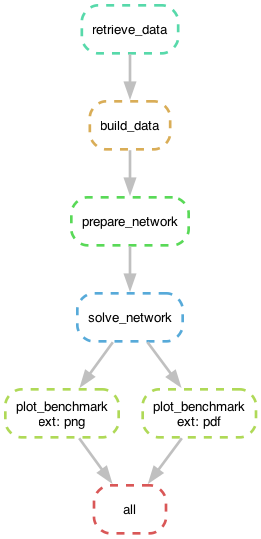

In [7]:
display(Image('dag_minimal.png'))

Alternatively, you can also visualize a filegraph like the figure above which includes also some information about the inputs and outputs to each of the rules.

You can reproduce the figure from above with the following command:
```
snakemake -call all --filegraph | dot -Tsvg > filegraph.svg
```

In [8]:
! snakemake -call all --filegraph | sed -n "/digraph/,\$p" | dot -Tsvg > filegraph_minimal.svg

Building DAG of jobs...


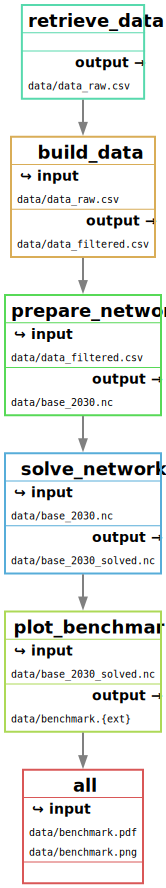

In [9]:
display(SVG('filegraph_minimal.svg'))

## Task 1: Executing a workflow with Snakemake

a) For our minimal example, execute a `dry-run` to produce the intermediate file `data/base_2030.nc`.

b) Execute the workflow and investigate what happens if you try to execute the workflow again.

c) Delete the final output files `data/benchmark.pdf` and investigate what happens if you try to execute the workflow again.

d) Import the raw input data file `data/data_raw.csv` using pandas and save it again overwriting the original file. Investigate what happens if you try to execute the workflow again. <br>
Hint: Alternative you can also just `touch` the file by executing `from pathlib import Path` and `Path("data/data_raw.csv").touch()`

e ) Finally, open the `Snakefile` and add a second rule that processes the file `data_raw_2.csv` using the same script as the `build_data` rule. Add the output of this new rule as a second input to the `prepare_network` rule.

## Using Snakemake to launch the open-TYNDP workflow

We have already retrieved a prebuilt version of the `open-tyndp` GitHub repository into our working directory...

The `open-tyndp` contains the following structure (directories which might be of particular interest to you are marked in bold):

- **benchmarks**: will store snakemake benchmarks (does not exist initially)
- **config**: configurations used in the study
- cutouts: will store raw weather data cutouts from atlite (does not exist initially)
- **data**: includes input data that is not produced by any snakemake rule. Various different input files are retrieved from external storage and stored in this directory
- doc: includes all files necessary to build the readthedocs documentation of PyPSA-Eur
- **envs**: includes all the mamba environment specifications to run the workflow
- logs: will store log files (does not exist initially)
- **notebooks**: includes all the notebooks used for ad-hoc analysis
- report: contains all files necessary to build the report; plots and result files are generated automatically
- **rules**: includes all the snakemake rules loaded in the Snakefile
- **resources**: will store intermediate results of the workflow which can be picked up again by subsequent rules (does not exist initially)
- **results**: will store the solved PyPSA network data, summary files and plots (does not exist initially)
- **scripts**: includes all the Python scripts executed by the snakemake rules to build the model

We now need to change our working directory to this new directory:

In [10]:
os.chdir('data/open-tyndp')

Let's check that we are indeed in the new directory now:

In [11]:
os.getcwd()

'/Users/daniel/Desktop/Work/OET/Projects/open-tyndp/code/open-tyndp-workshops/open-tyndp-workshops/data/open-tyndp'

We can now use Snakemake to call some of the rules to produce outputs with the `open-tyndp` PyPSA model. 

We will use the prepared TYNDP configuration file (`config/config.tyndp.yaml`) and schedule a dry-run with `-n` as we only want to investigate the DAG of the workflow:

In [12]:
! snakemake -call all --configfile config/config.tyndp.yaml -n

Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-14
host: Mac.home
Building DAG of jobs...
Job stats:
job                                                 count
------------------------------------------------  -------
add_brownfield                                          6
add_electricity                                         3
add_existing_baseyear                                   3
add_transmission_projects_and_dlr                       3
all                                                     1
base_network                                            3
build_ammonia_production                                3
build_bidding_zones                                     3
build_biomass_potentials                                9
build_biomass_transport_costs                           3
build_central_heating_temperature_profiles              9
build_clustered_population_layouts                      3
build_cop_profiles                             

The corresponding rule graph to this workflow will look like this:

In [13]:
! snakemake -call all -F --rulegraph | sed -n "/digraph/,\$p" | dot -Tpng > rulegraph_open_tyndp.png

Building DAG of jobs...


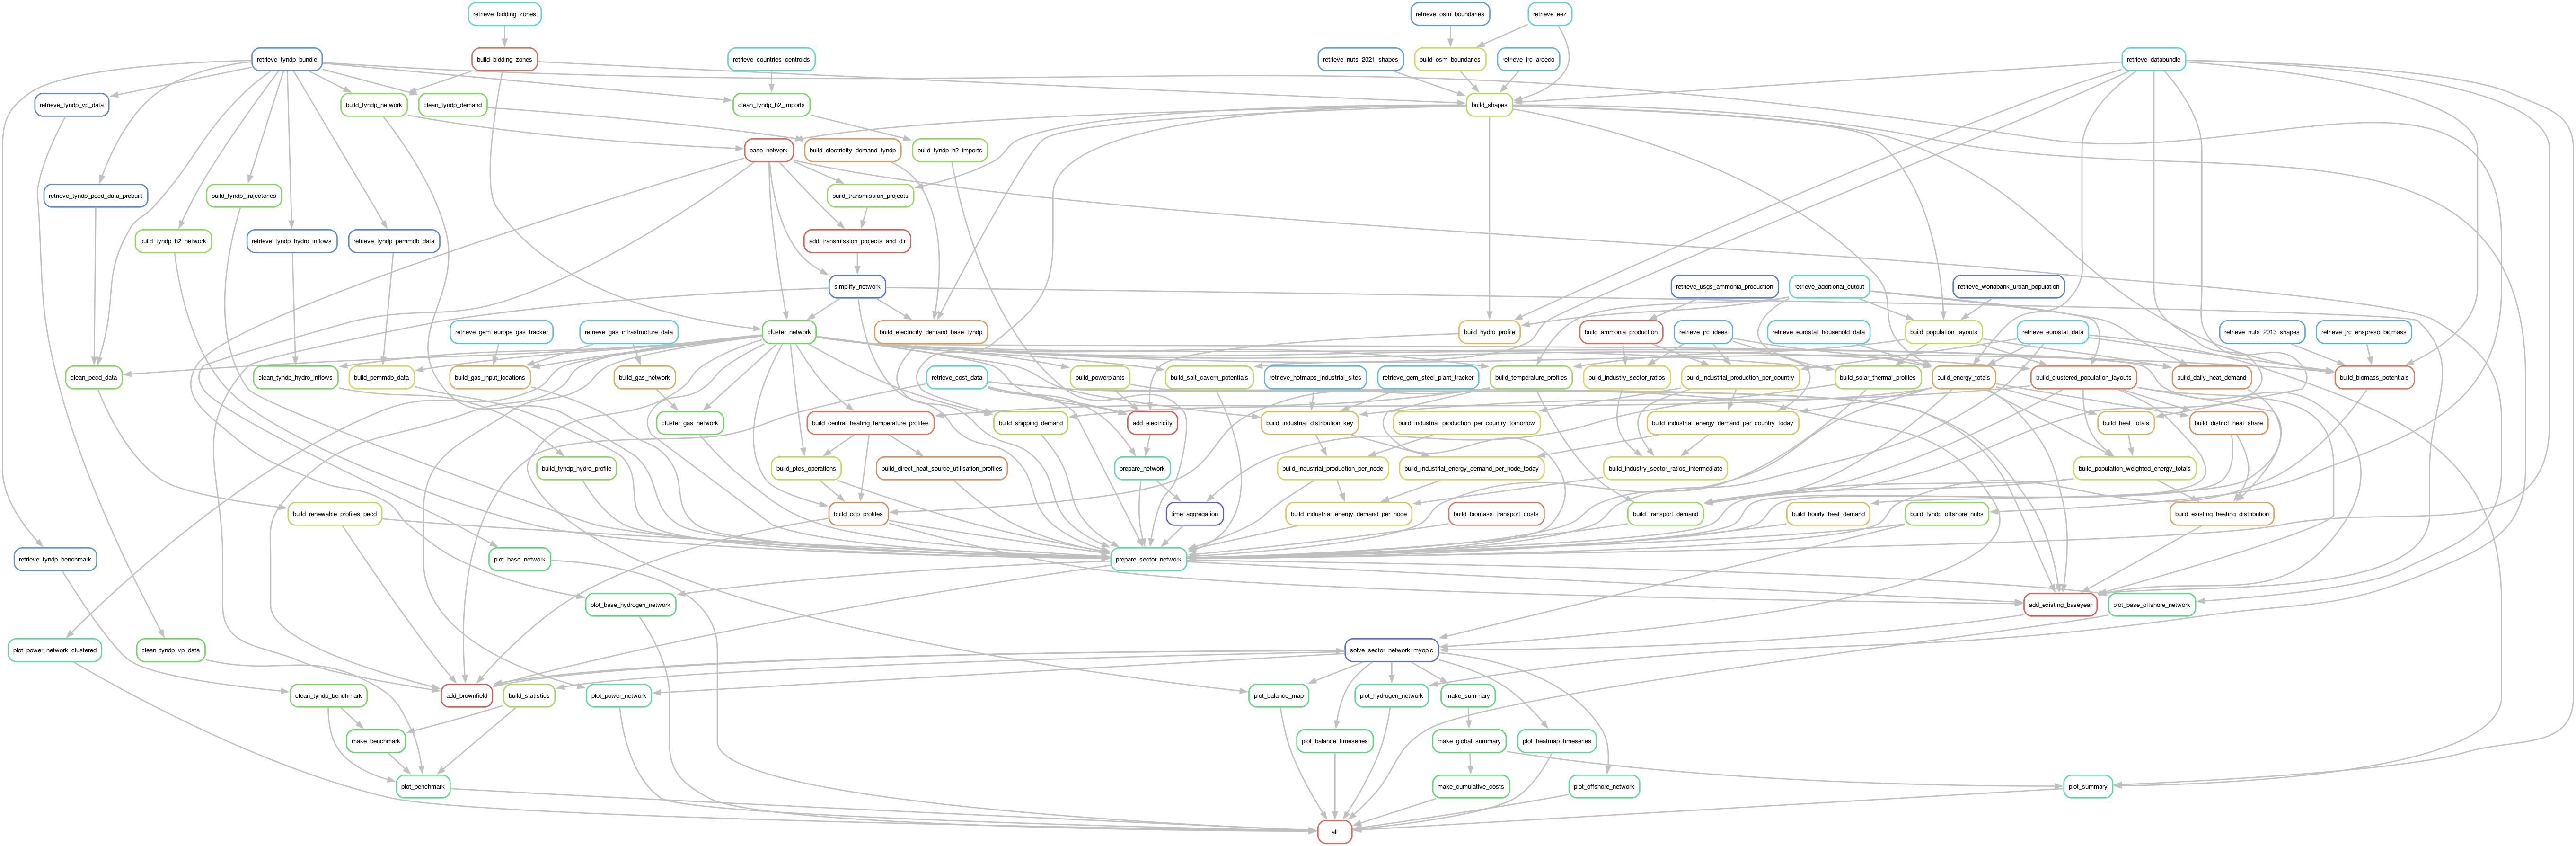

In [14]:
display(Image("rulegraph_open_tyndp.png"))

As you can see this workflow is much more complicated than our minimal example from the beginning.

However, the general idea remains the same. We retrieve data wich we consequently process, then we prepare the model network and we solve it before we postprocess the results (summary, plotting, benchmarks).

:::{note}
If you are executing this notebook on your local machine, you can also use the `conda` package manager to install the `open-tyndp` environment and run the workflow instead of dry-runs:
```
conda env create --file envs/<YourSystemOS>-pinned.yaml
```
:::

## Task 2: Adjusting the Open-TYNDP workflow with the configuration file

a) Make some changes in the configuration file and call another **dry-run** of the `open-tyndp` model again to see the changes to the workflow.

# Update on new features

In [16]:
# For the purposes of this workshop we will primarily focus on the National Trends (NT) scenario

## Time Series

In [17]:
# read network
# --- Electricity demand
# --- PECD
# look for renewables components
# Explain / remind difference between time varying and fixed attributes, how to access them
# Plot both time of parameters
# Compare to Report

First, we will import the solved network for the National Trends (NT) scenario for 2030 and 2040

In [ ]:
# hourly networks
# n_2030_NT = pypsa.Network("../base_s_all___2030.nc")

INFO:pypsa.network.io:Imported network 'PyPSA-Eur (tyndp)' has buses, carriers, generators, global_constraints, links, loads, shapes, storage_units, stores


In [18]:
n_2030_NT = pypsa.Network("results/tyndp/NT/networks/base_s_all___2030.nc")
n_2040_NT = pypsa.Network("results/tyndp/NT/networks/base_s_all___2040.nc")

INFO:pypsa.network.io:Imported network 'PyPSA-Eur (tyndp)' has buses, carriers, generators, global_constraints, links, loads, shapes, storage_units, stores
INFO:pypsa.network.io:Imported network 'PyPSA-Eur (tyndp)' has buses, carriers, generators, global_constraints, links, loads, shapes, storage_units, stores


### Electricity demand

We can then explore the electricity demand that is attached to the network. Can you remember how to access `Loads` timeseries in PyPSA?

Correct! You can use the `loads_t` key and its `p_set` attribute:

In [245]:
loads_2030 = n_2030_NT.loads_t.p_set
display(loads_2030)

Load,AL00,AT00,BA00,BE00,BG00,CH00,CY00,CZ00,DE00,DKE1,...,PL00,PT00,RO00,RS00,SE01,SE02,SE03,SE04,SI00,SK00
snapshot,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,947.959412,9823.934937,1139.898666,12242.365509,5565.920746,7166.768456,514.413109,7134.304718,75929.264656,2167.298187,...,17104.075562,6068.504311,6906.502472,7191.248100,1653.199226,2470.068657,11584.612106,3193.297096,1356.612617,2899.493263
2009-01-01 01:00:00,833.057487,9821.063911,1086.608055,11888.769669,5414.886581,6796.788185,500.234436,7121.448853,73368.054413,2089.113052,...,16892.143913,5704.324791,6925.691902,6284.783302,1652.897522,2457.466545,11492.949509,3166.825447,1335.408936,3076.165970
2009-01-01 02:00:00,764.375237,9742.805717,1035.842484,11542.755981,5312.423264,6770.658478,491.265236,7024.643143,72445.216782,2038.800095,...,16826.266251,5277.870186,7063.218033,5642.247635,1648.209999,2433.868546,11348.999016,3118.911705,1323.218330,2980.385391
2009-01-01 03:00:00,732.734497,9807.876175,1011.463104,11343.939415,5259.545975,6653.832253,508.105309,6944.713936,73673.191757,2032.129326,...,17360.237389,5090.429459,7446.547157,5022.270302,1649.819946,2428.670639,11205.289032,3069.691803,1330.600349,3013.437683
2009-01-01 04:00:00,738.262611,9821.234138,1004.053360,11586.468903,5135.470093,6915.888031,555.610298,6776.687698,77914.759674,2045.791275,...,16662.134514,5030.606117,8229.326569,4536.644714,1671.352608,2452.380264,11084.080399,3037.241516,1424.730194,3260.762955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-31 19:00:00,1373.464699,10186.148743,1759.692863,15248.790779,4182.003387,7903.814400,593.870850,9780.208969,83013.724785,3162.549820,...,21415.983917,8278.993614,8011.779816,7386.358940,1704.617928,2573.828400,13637.076744,4266.942131,2110.339989,3997.240417
2009-12-31 20:00:00,1298.596481,9741.117981,1703.546410,14638.423149,4399.966461,7702.077904,528.606934,9172.921196,78526.535805,3036.251060,...,20396.652702,7953.916534,7450.904747,7163.827873,1655.813515,2519.093506,13190.296402,4068.069672,1967.399399,3751.159470
2009-12-31 21:00:00,1171.280190,9591.628250,1619.161339,14571.613136,4800.739456,7781.802017,460.162979,8635.920441,74752.871979,2866.214302,...,19748.090439,7444.483284,6886.228134,6934.681305,1586.528893,2450.534973,12701.352257,3869.028137,1833.435646,3556.156662


Let's plot these electricity demand time series:

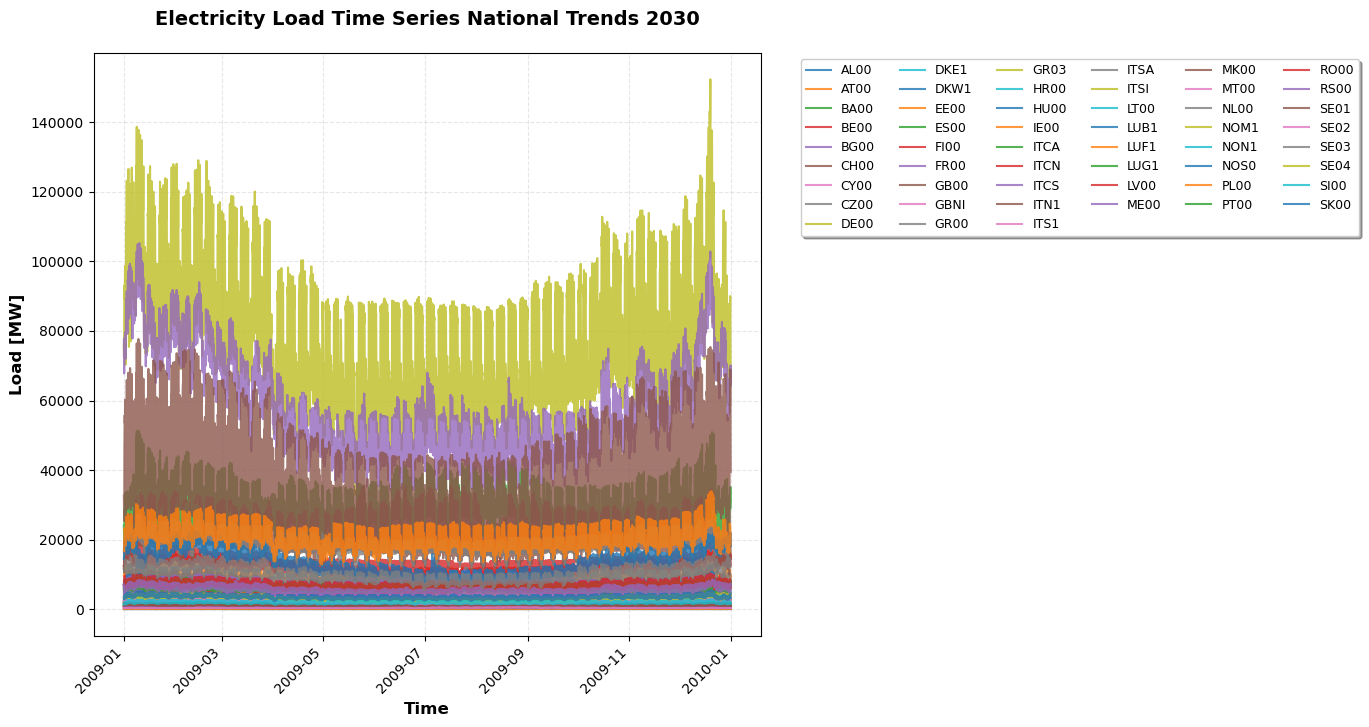

In [246]:
# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot each load time series
for load in loads_2030.columns:
    ax.plot(loads_2030.index, loads_2030[load], label=load, linewidth=1.5, alpha=0.8)

# Formatting
ax.set_xlabel("Time", fontsize=12, fontweight='bold')
ax.set_ylabel("Load [MW]", fontsize=12, fontweight='bold')
ax.set_title("Electricity Load Time Series National Trends 2030", fontsize=14, fontweight='bold', pad=20)

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

# Legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
          frameon=True, shadow=True, fontsize=9, ncols=6)
plt.tight_layout()
plt.xticks(rotation=45, ha='right');

This is very confusing to look at. Let's filter that down a bit...

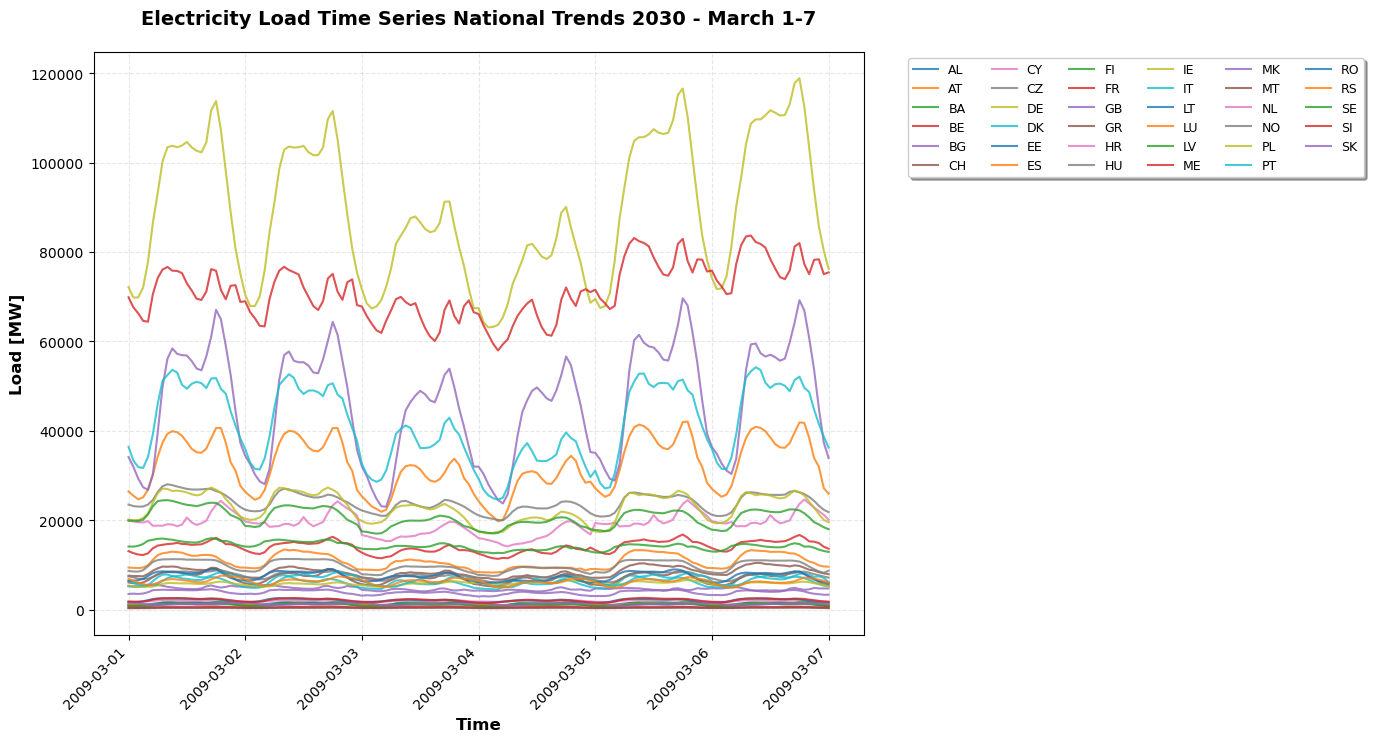

In [269]:
# group country profiles together
country_mapping = n_2030_NT.buses.query("carrier=='AC'").country
loads_2030_by_country = (
    n_2030_NT
    .loads_t
    .p_set.T
    .rename(country_mapping, axis=0)
    .groupby("Load").sum().T
    .query("index  >= '2009-03-01' and index <= '2009-03-07'")
)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot each load time series
for load in loads_2030_by_country.columns:
    ax.plot(loads_2030_by_country.index, loads_2030_by_country[load], label=load, linewidth=1.5, alpha=0.8)

# Formatting
ax.set_xlabel("Time", fontsize=12, fontweight='bold')
ax.set_ylabel("Load [MW]", fontsize=12, fontweight='bold')
ax.set_title("Electricity Load Time Series National Trends 2030 - March 1-7", fontsize=14, fontweight='bold', pad=20)

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

# Legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
          frameon=True, shadow=True, fontsize=9, ncols=6)
plt.tight_layout()
plt.xticks(rotation=45, ha='right');

#### Task: Can you remember how to use the **PyPSA Statistics** module that we introduced in the last workshop to interactively visualize these electricity demand inputs from the network:

In [249]:
# let's fill missing colors first
n_2030_NT.carriers.loc["none", "color"] = "#000000"
n_2030_NT.carriers.loc["", "color"] = "#000000"
# and define a helper variable
s = n_2030_NT.statistics

In [271]:
s.withdrawal(bus_carrier="low voltage", comps="Load", aggregate_time=False, groupby=False).T

Load,AL00,AT00,BA00,BE00,BG00,CH00,CY00,CZ00,DE00,DKE1,...,PL00,PT00,RO00,RS00,SE01,SE02,SE03,SE04,SI00,SK00
snapshot,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


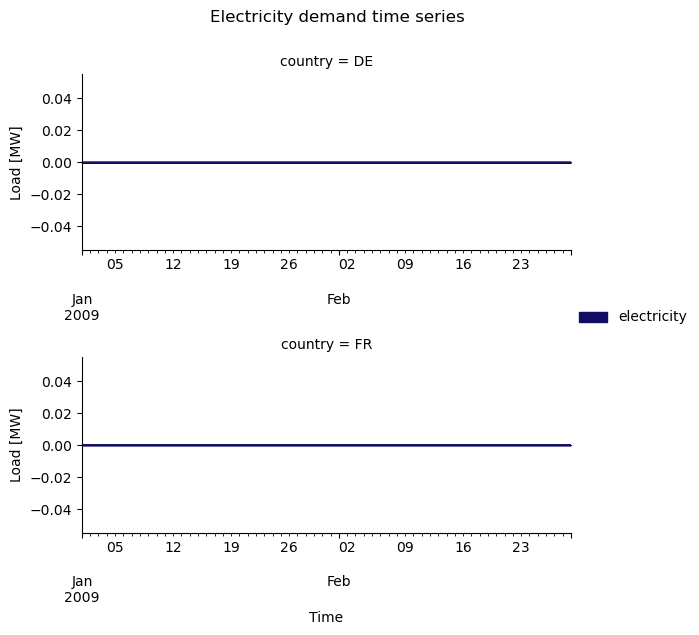

In [272]:
fig, ax, facet_col  = s.withdrawal.plot.area(
    bus_carrier="low voltage",
    y="value",
    x="snapshot",
    color="carrier",
    stacked=True,
    facet_row="country",
    query="carrier == 'electricity' and country in ['DE', 'FR'] and snapshot < '2009-03'",
)
fig.suptitle('Electricity demand time series', y=1.05)
ax[0,0].set_ylabel("Load [MW]")
ax[1,0].set_ylabel("Load [MW]")
ax[1,0].set_xlabel("Time");

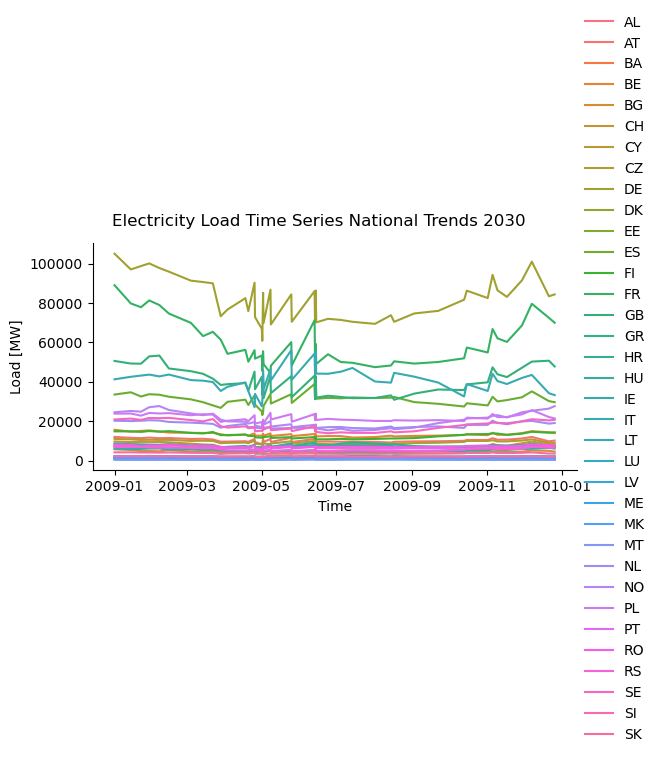

In [241]:
fig, ax, facet_col  = s.withdrawal.plot.line(
    bus_carrier="low voltage",
    y="value",
    x="snapshot",
    color="country",
    stacked=True,
    **dict(legend=dict(ncols=4))
)
fig.suptitle('Electricity Load Time Series National Trends 2030', y=1.05)
ax.set_ylabel("Load [MW]")
ax.set_xlabel("Time");

### PECD capacity factors

Let's look at the capacity factor time series for solar PV Utility for 2030

In [290]:
cf_pv_util = pd.read_csv("resources/tyndp/NT/pecd_data_LFSolarPVRooftop_2030.csv", index_col=0, parse_dates=True)

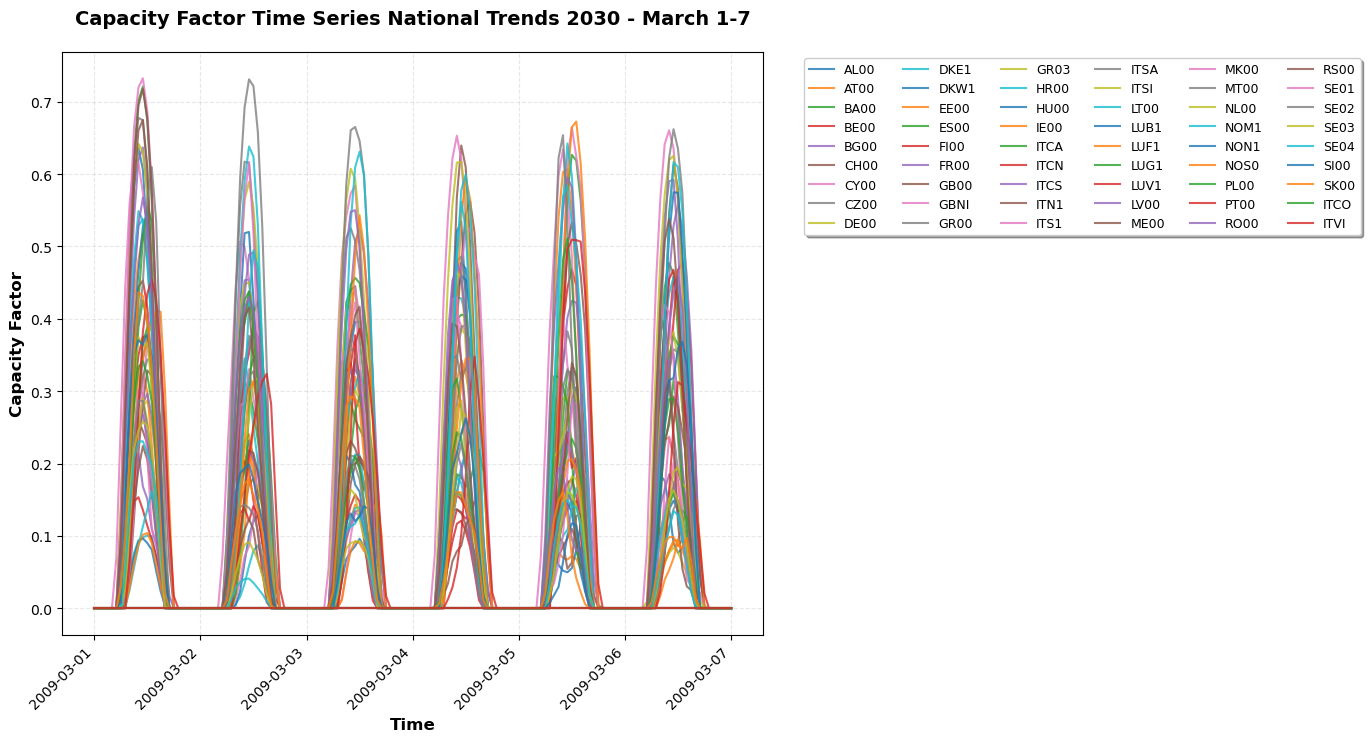

In [291]:
loads_2030_by_country = (
    cf_pv_util
    .query("index  >= '2009-03-01' and index <= '2009-03-07'")
)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot each load time series
for load in loads_2030_by_country.columns:
    ax.plot(loads_2030_by_country.index, loads_2030_by_country[load], label=load, linewidth=1.5, alpha=0.8)

# Formatting
ax.set_xlabel("Time", fontsize=12, fontweight='bold')
ax.set_ylabel("Capacity Factor", fontsize=12, fontweight='bold')
ax.set_title("Capacity Factor Time Series National Trends 2030 - March 1-7", fontsize=14, fontweight='bold', pad=20)

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

# Legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
          frameon=True, shadow=True, fontsize=9, ncols=6)
plt.tight_layout()
plt.xticks(rotation=45, ha='right');

## Onshore wind and solar

In [ ]:
# Showcase trajectories in a plot
# import trajectories.csv for DE/GA

## Offshore Hubs

In [29]:
# read network
# plot OH hubs maps
# Constraitns
# capacities
# questions

## H2 imports

In [31]:
# read network
# plot H2 map with import corridors
# table to showcase the corridors
# optional: Task to investigate values

# Benchmarking framework

In [ ]:
# Present metrics used (incl. reference to methodology)
# Data sources used for comparison
# Mention introduction of onwind and solar
# Showcase current status
# --- Table
# --- Graphs

# Wrap up

In [33]:
# Collect feeback via Slido